- Lectura de información o Corpus
- Preprocesamiento del texto
- Creación de las matrices de entradas (X) y de salidas (Y)
- Creación de la matriz de embeddings para el diccionario de tu corpus
- Definición de los modelos DNN CNN y LSTM MULTICLASE (Con los
hiperparámetros que consideres más adecuados)
- Entrenamiento de los modelos
- Muestra gráfica del accuracy y pérdida de cada uno de los modelos
- Matriz de confusión para cada uno de los modelos.

In [2]:
# Importar todas las librerías que se utilizarán
import pandas as pd 
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import os

from numpy import array
from keras_preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM, GlobalMaxPooling1D, Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from nltk.tokenize import RegexpTokenizer, TreebankWordDetokenizer

import matplotlib.pyplot as plt

# Filtrado de StopWords utilizando NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [3]:
def build_corpus(root_folder):
    """Este método lee los de datos del corpus, que serían la serie de textos relacionados a Libros, Animales,
        Personas famosas, Lugares, Objetos y Series (la categoría agregada)

    Args:
        root folder (string): Es la carpeta que contiene a los textos a procesar
        
    Returns:
        corpus (diccionario): Es el conjunto de textos divididos por categorías donde las categorías son las
        llaves y los datos son los textos
    """
    
    corpus = {}

    # Se va por la carpeta 
    for dirpath, dirnames, filenames in os.walk(root_folder):
        
        # Si encuentra la carpeta deseada que continue
        if dirpath == root_folder:
            continue
        
        # Una vez encuentra la carpeta que contiene otras carpetas, se guarda el nombre y hace éste la llave del corpus
        folder_name = os.path.basename(dirpath)
        corpus[folder_name] = []
        
        # Se itera por los nombres de archivos que se tienen dentro de la carpeta de cada categoría
        for filename in filenames:
            
            # Se asegura que estemos leyendo puros archivos de texto (que terminen con .txt)
            if filename.endswith('.txt'):
                filepath = os.path.join(dirpath, filename)
                with open(filepath, 'r') as file:
                    
                    # Se leen los archivos de texto y se guardan en el corpus 
                    content = file.read()
                    corpus[folder_name].append(content)
                    
    # Se regresa el corpus con toda la información requerida
    return corpus


In [4]:
from nltk.tokenize import RegexpTokenizer, TreebankWordDetokenizer

def preprocess_text(corpus):
    """Este método hace el preprocesamiento del corpus

    Args:
        corpus (diccionario): Contiene la información a preprocesar
        
    Returns:
        X_processed (lista): Es una lista que contiene los textos preprocesados
    """
    
    # Se inicializa las variables necesarias
    stop_words = set(stopwords.words('spanish'))
    X_processed = []
    removedor_tags = re.compile(r'<[^>]+>')
    
    # Se va por cada uno de los textos y los guarda en la variable
    sentences = [text for sublist in corpus.values() for text in sublist]
    
    # Se itera por los textos
    for sen in sentences:
        
        # Se reemplazan stopwords 
        for stopword in stop_words:
            sen = sen.replace(" " + stopword + " ", " ")
            
        # Se quitan los tags
        sen = removedor_tags.sub('', sen)
        
        # Se transforma todo a minúsculas
        sen = re.sub(r'\s+', ' ', sen).strip().lower()
        
        # Se tokenizan solo las palabras
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(sen)
        
        # Se destoqueniza y se guarda en una variable
        processed_sentence = TreebankWordDetokenizer().detokenize(tokens)
        
        # Se agrega a una lista que contendrá todos los textos
        X_processed.append(processed_sentence)
    
    # Se regresa la lista preprocesada
    return X_processed


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

def create_matrix(corpus):
    """Este método crea una matriz para clasificar los textos

    Args:
        corpus (diccionario): Contiene la información inicial con categorías y textos
        
    Returns:
        X, Y: Son la matrices de entrada y salida
    """
    
    # Se llama al método que preprocesa la información y se guarda en una variable
    X_processed = preprocess_text(corpus)
    vectorizer = CountVectorizer()
    
    # Se vectoriza y crea la matriz y se guarda la categoría
    X = vectorizer.fit_transform(X_processed)
    Y = [label for label, texts in corpus.items() for _ in texts]
    
    # Se regresa la matriz y la categoría
    return X, Y, X_processed

In [6]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

def Training_Data(X_processed, Y):
    """Este método crea las variables de X y Y train y test

    Args:
       corpus (diccionario): Es un diccionario que tiene los textos
        
    Returns:
        X, Y: Son la matrices de entrada y salida con el proceso ya hecho
    """

    # Se hace el split de los textos que usará para entrenar y para validar
    X_train_texts, X_test_texts, y_train, y_test = train_test_split(X_processed, Y, test_size=0.20)
    
    # Se hace el tokenizer
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(X_train_texts)
    
    # Se ajusta a valores los X_train y X_test
    X_train = tokenizer.texts_to_sequences(X_train_texts)
    X_test = tokenizer.texts_to_sequences(X_test_texts)
    
    # regresa los valores de X y Y de train y test
    return X_train, X_test, y_train, y_test, tokenizer

In [7]:
def Padding(X_train, X_test):
    """Este método hace el padding 

    Args:
        X_train, X_test: son las matrices de entrenamiento y testeo a las que se hará el padding
        
    Returns:
        X, Y: Son la matrices de entrada y salida con el proceso ya hecho
    """
    
    # Se establece una longitud máxima para el padding
    maxlen = 150
    
    # Se hace el padding en los valores de entrenamiento y de testeo
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
    
    #Se imprimen los valores
    print("Matriz de valores para las palabras:")
    X_train.shape
    print(X_train)
    print(y_train)
    
    # Regresa el X_train y X_test con el padding
    return X_train, X_test

In [8]:
from numpy import asarray
from numpy import zeros

def Embeddings(tokenizer):
    """Este método contiene todo lo necesario para la creación y lectura de embedding así como sus 
       características necesarias

    Args:
        Este método no contiene argumentos
        
    Returns:
        embedding_matrix (matriz): Es la matriz con los pesos del archivo Word2Vect
    """
    
    #Se inicializa la variable de diccionario y se lee el 
    embeddings_dictionary = dict()
    Embeddings_file = open('Word2Vect_Spanish.txt', encoding="utf8")

    # Se leen los datos del archivo de embeddings
    for linea in Embeddings_file:
        caracts = linea.split()
        palabra = caracts[0]
        vector = asarray(caracts[1:], dtype='float32')
        embeddings_dictionary [palabra] = vector
    Embeddings_file.close()
    
    # Se inicializa el tamaño para la matriz de embeddings
    vocab_size = len(tokenizer.word_index) + 1

    # Se crea y hace la matriz de embeddings
    embedding_matrix = zeros((vocab_size, 300))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
            
    # regresa la matriz de embeddings
    return embedding_matrix, vocab_size

In [9]:
import matplotlib.pyplot as plt

def Show_Graphics(history):
    """Este método imprime las gráficas del train y test y su accurancy

    Args:
        history: son las épocas por las que pasó el proceso para aprender
        
    Returns:
        no regresa nada
    """
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def DNN(vocab_size, embedding_matrix, maxlen, y_train, y_test, X_train, X_test):
    """Este método hace la red neuronal con el método de DNN

    Args:
        vocab_size (int): es el tamaño del embedding
        embedding_matrix (matriz): es la matriz de pesos
        maxlen (int): es el máximo del input de la embedding
        y_train, y_test, x_train, x_test: son las matrices de entrenamiento y validación en x y y
        
    Returns:
        no regresa nada
    """
    # Definición del modelo
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)
    model.add(embedding_layer)
    model.add(Flatten())
    model.add(Dense(5, activation='sigmoid'))
    print(model.summary())

    # Codificación de etiquetas
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.transform(y_test)
    y_train_np = to_categorical(y_train_encoded)
    y_test_np = to_categorical(y_test_encoded)

    # Compilación del modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
     # Se hace el Padding
    X_train_padded, X_test_padded = Padding(X_train, X_test)

    # Utilizamos el método fit para ajustar los datos de nuestro modelo a la configuración que definimos
    history = model.fit(X_train_padded, y_train_np, batch_size=10, epochs=30, verbose=1, validation_split=0.2)

    score = model.evaluate(X_test_padded, y_test_np, verbose=1)
    print("Test Loss:", score[0])
    print("Test Accuracy:", score[1])
    
    Show_Graphics(history)
    Confussion_Matrix(X_train, X_test, y_test_np, model)

In [42]:
def CNN(vocab_size, embedding_matrix, maxlen, y_train, y_test, X_train, X_test):
    """Este método hace la red neuronal con el método de CNN

    Args:
        vocab_size (int): es el tamaño del embedding
        embedding_matrix (matriz): es la matriz de pesos
        maxlen (int): es el máximo del input de la embedding
        y_train, y_test, x_train, x_test: son las matrices de entrenamiento y validación en x y y
        
    Returns:
        no regresa nada
    """
    # Declaración de modelo Secuencial 
    model = Sequential()

    # Declaración de las capas del modelo convolucional
    embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    model.add(embedding_layer)
    model.add(Dense(64, activation='relu'))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(5, activation='sigmoid'))
    # Impresión de parámetros del modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    # Codificación de etiquetas
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.transform(y_test)
    y_train_np = to_categorical(y_train_encoded)
    y_test_np = to_categorical(y_test_encoded)

    # Compilación del modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
     # Se hace el Padding
    X_train_padded, X_test_padded = Padding(X_train, X_test)

    # Utilizamos el método fit para ajustar los datos de nuestro modelo a la configuración que definimos
    history = model.fit(X_train_padded, y_train_np, batch_size=10, epochs=30, verbose=1, validation_split=0.2)

    score = model.evaluate(X_test_padded, y_test_np, verbose=1)
    print("Test Loss:", score[0])
    print("Test Accuracy:", score[1])
    
    Show_Graphics(history)
    Confussion_Matrix(X_train, X_test, y_test_np, model)

In [43]:
from tensorflow.keras.layers import LSTM

def LSTM_model(vocab_size, embedding_matrix, maxlen, y_train, y_test, X_train, X_test):
    """Este método hace la red neuronal con el método de LSTM

    Args:
        vocab_size (int): es el tamaño del embedding
        embedding_matrix (matriz): es la matriz de pesos
        maxlen (int): es el máximo del input de la embedding
        y_train, y_test, x_train, x_test: son las matrices de entrenamiento y validación en x y y
        
    Returns:
        no regresa nada
    """
    model = Sequential()

    # Declaración de las capas del modelo LSTM
    embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=True)
    model.add(embedding_layer)
    model.add(LSTM(64))
    model.add(Dense(5, activation='sigmoid'))

    # Impresión de parámetros del modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    # Codificación de etiquetas
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.transform(y_test)
    y_train_np = to_categorical(y_train_encoded)
    y_test_np = to_categorical(y_test_encoded)

    # Compilación del modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
     # Compilación del modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
     # Se hace el Padding
    X_train_padded, X_test_padded = Padding(X_train, X_test)

    # Utilizamos el método fit para ajustar los datos de nuestro modelo a la configuración que definimos
    history = model.fit(X_train_padded, y_train_np, batch_size=10, epochs=30, verbose=1, validation_split=0.2)

    score = model.evaluate(X_test_padded, y_test_np, verbose=1)
    print("Test Loss:", score[0])
    print("Test Accuracy:", score[1])
    
    Show_Graphics(history)
    Confussion_Matrix(X_train, X_test, y_test_np, model)

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

def Confussion_Matrix(X_train, X_test, y_test_np, model):
    """Este método hace la matriz de confusión

    Args:
        X_train, X_test: son los X entrenados y de testeo
        y_test_np: es el valor de testeo de y con numpy
        
    Returns:
        no regresa nada
    """
    
    X_train_padded, X_test_padded = Padding(X_train, X_test)

    y_pred = model.predict(X_test_padded)
    y_pred_classes = np.argmax(y_pred, axis=1)

    y_true_classes = np.argmax(y_test_np, axis=1)

    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(10,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusión')
    plt.colorbar()

    classes = sorted(set(y_true_classes))
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.show()

## Pipeline del proceso

In [14]:
# Se leen los archivos
root_folder = 'Textos_para_Clasificar'
corpus = build_corpus(root_folder)
print(corpus)

{'Series': ['"Gossip Girl" sigue las vidas de un grupo de jóvenes de la elite de Nueva York, narradas por una bloguera anónima que expone sus secretos y escándalos.\nLos personajes navegan por un mundo de riqueza, poder, y romance, mientras enfrentan las presiones de la expectativa social y las complicaciones de la adultez emergente. \nLa serie es tanto una crítica como una exposición glamorosa de la alta sociedad, explorando cómo la juventud adinerada se enfrenta a los desafíos de la vida bajo el escrutinio público y el ojo vigilante de "Gossip Girl".', 'La serie "Boy Meets World" sigue la vida de Cory Matthews desde la infancia hasta la adultez. \nA través de las siete temporadas, se explora la evolución de Cory, desde un joven curioso hasta un adulto maduro, enfrentando desafíos de la vida cotidiana. \nA lo largo de la serie, Cory aprende lecciones valiosas sobre la amistad, el amor, y la responsabilidad, guiado por su maestro y mentor, el Sr. Feeny. \nSu relación con su mejor amigo

In [15]:
# Se hace la matriz
X, Y, X_processed = create_matrix(corpus)
print(X_processed)

['gossip girl sigue vidas grupo jóvenes elite nueva york narradas bloguera anónima expone secretos escándalos los personajes navegan mundo riqueza poder romance mientras enfrentan presiones expectativa social complicaciones adultez emergente la serie crítica exposición glamorosa alta sociedad explorando cómo juventud adinerada enfrenta desafíos vida bajo escrutinio público ojo vigilante gossip girl', 'la serie boy meets world sigue vida cory matthews infancia adultez a través siete temporadas explora evolución cory joven curioso adulto maduro enfrentando desafíos vida cotidiana a largo serie cory aprende lecciones valiosas amistad amor responsabilidad guiado maestro mentor sr feeny su relación mejor amigo shawn novia topanga familia proporciona mirada cálida humorística vida adolescente suburbios estadounidenses', 'stranger things serie ciencia ficción horror desarrolla década 1980 un grupo niños pequeña ciudad hawkins indiana descubren mundo secretos gubernamentales dimensiones parale

In [16]:
# Se inicializan las variables de entrenamiento
X_train, X_test, y_train, y_test, tokenizer = Training_Data(X_processed, Y)

In [17]:
# Se hace la matriz de embeddings
embedding_matrix, vocab_size = Embeddings(tokenizer)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 150, 300)          659100    
                                                                 
 flatten_2 (Flatten)         (None, 45000)             0         
                                                                 
 dense_10 (Dense)            (None, 5)                 225005    
                                                                 
Total params: 884,105
Trainable params: 225,005
Non-trainable params: 659,100
_________________________________________________________________
None
Matriz de valores para las palabras:
[[ 187  329  120 ...    0    0    0]
 [ 744  209  745 ...  803  804  221]
 [  14  133  805 ...    0    0    0]
 ...
 [2028  225  633 ...  335 2090 2091]
 [  10   42 2092 ...    0    0    0]
 [2142  130 2143 ...  643 2196   20]]
['Objetos', 'Lugares', 'Animales', 

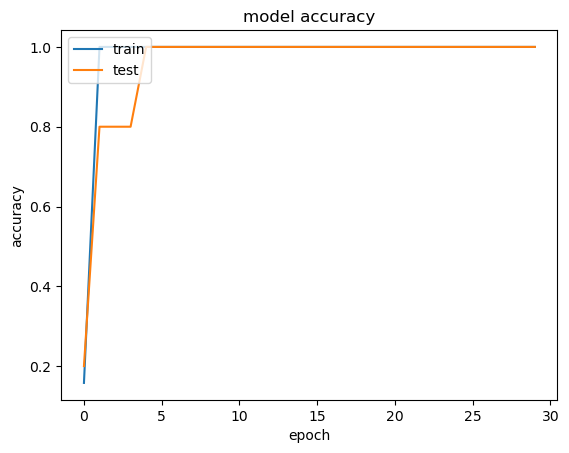

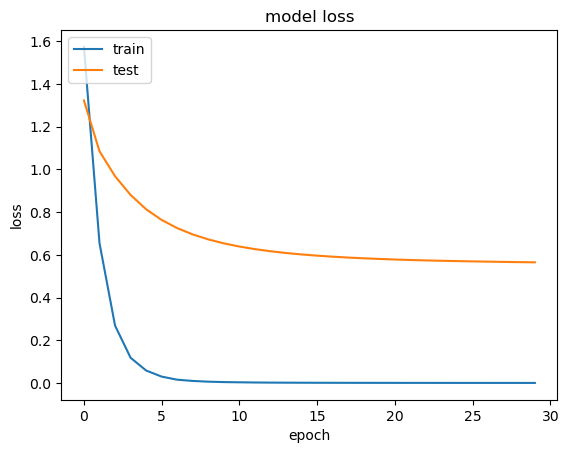

Matriz de valores para las palabras:
[[ 187  329  120 ...    0    0    0]
 [ 744  209  745 ...  803  804  221]
 [  14  133  805 ...    0    0    0]
 ...
 [2028  225  633 ...  335 2090 2091]
 [  10   42 2092 ...    0    0    0]
 [2142  130 2143 ...  643 2196   20]]
['Objetos', 'Lugares', 'Animales', 'Lugares', 'Lugares', 'Animales', 'Personas', 'Series', 'Personas', 'Series', 'Personas', 'Series', 'Objetos', 'Personas', 'Animales', 'Objetos', 'Lugares', 'Animales', 'Series', 'Lugares', 'Animales', 'Animales', 'Series', 'Lugares']
1/1 [==============================] - 0s 23ms/step


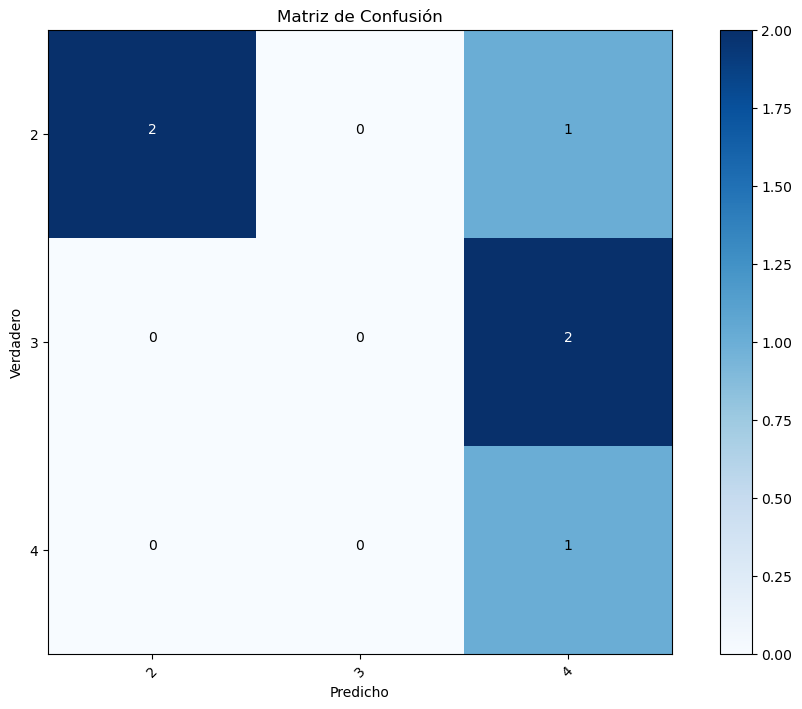

In [44]:
# Se hace la red neuronal de DNN
DNN(vocab_size, embedding_matrix, 150, y_train, y_test, X_train, X_test)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 150, 300)          659100    
                                                                 
 dense_11 (Dense)            (None, 150, 64)           19264     
                                                                 
 conv1d_2 (Conv1D)           (None, 146, 128)          41088     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 5)                 645       
                                                                 
Total params: 720,097
Trainable params: 60,997
Non-trainable params: 659,100
__________________________________________

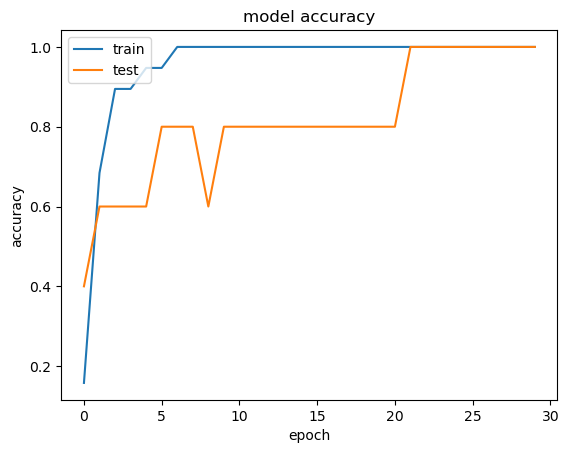

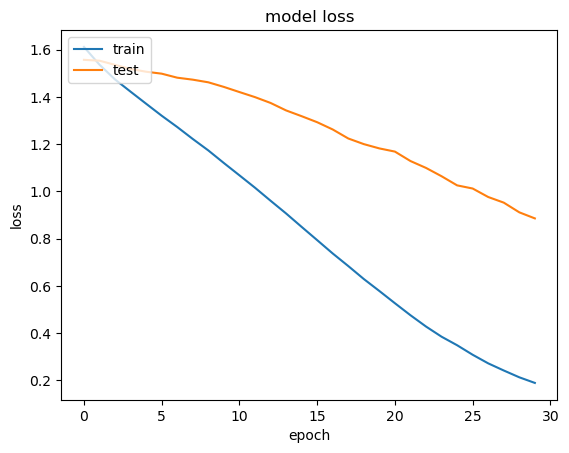

Matriz de valores para las palabras:
[[ 187  329  120 ...    0    0    0]
 [ 744  209  745 ...  803  804  221]
 [  14  133  805 ...    0    0    0]
 ...
 [2028  225  633 ...  335 2090 2091]
 [  10   42 2092 ...    0    0    0]
 [2142  130 2143 ...  643 2196   20]]
['Objetos', 'Lugares', 'Animales', 'Lugares', 'Lugares', 'Animales', 'Personas', 'Series', 'Personas', 'Series', 'Personas', 'Series', 'Objetos', 'Personas', 'Animales', 'Objetos', 'Lugares', 'Animales', 'Series', 'Lugares', 'Animales', 'Animales', 'Series', 'Lugares']
1/1 [==============================] - 0s 39ms/step


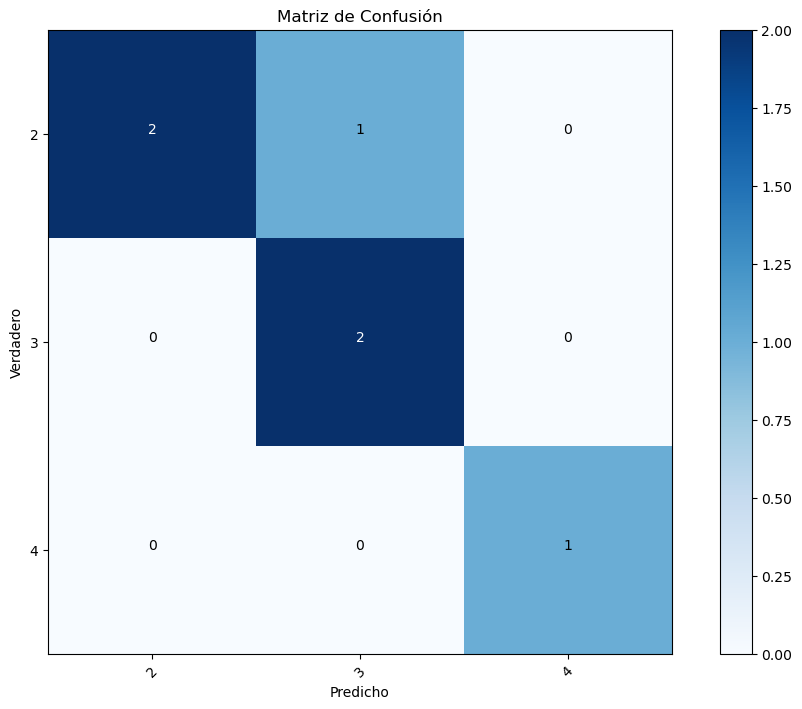

In [45]:
# Se hace la red neuronal de CNN
CNN(vocab_size, embedding_matrix, 150, y_train, y_test, X_train, X_test)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 150, 300)          659100    
                                                                 
 lstm_3 (LSTM)               (None, 64)                93440     
                                                                 
 dense_9 (Dense)             (None, 5)                 325       
                                                                 
Total params: 752,865
Trainable params: 752,865
Non-trainable params: 0
_________________________________________________________________
None
Matriz de valores para las palabras:
[[ 187  329  120 ...    0    0    0]
 [ 744  209  745 ...  803  804  221]
 [  14  133  805 ...    0    0    0]
 ...
 [2028  225  633 ...  335 2090 2091]
 [  10   42 2092 ...    0    0    0]
 [2142  130 2143 ...  643 2196   20]]
['Objetos', 'Lugares', 'Animales', 'Lugar

2023-10-20 22:07:43.315282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-20 22:07:43.316147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-20 22:07:43.316675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 214ms/step - loss: 1.6106 - accuracy: 0.2105 - val_loss: 1.5687 - val_accuracy: 0.6000
Epoch 2/30
1/2 [==============>...............] - ETA: 0s - loss: 1.5646 - accuracy: 0.7000

2023-10-20 22:07:44.108529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-20 22:07:44.109122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-20 22:07:44.109641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 60ms/step - loss: 1.5522 - accuracy: 0.5789 - val_loss: 1.5347 - val_accuracy: 0.6000
Epoch 3/30
2/2 [==============================] - 0s 60ms/step - loss: 1.5017 - accuracy: 0.6316 - val_loss: 1.4927 - val_accuracy: 0.6000
Epoch 4/30
2/2 [==============================] - 0s 66ms/step - loss: 1.4445 - accuracy: 0.6316 - val_loss: 1.4433 - val_accuracy: 0.6000
Epoch 5/30
2/2 [==============================] - 0s 63ms/step - loss: 1.3775 - accuracy: 0.6316 - val_loss: 1.4004 - val_accuracy: 0.6000
Epoch 6/30
2/2 [==============================] - 0s 63ms/step - loss: 1.3000 - accuracy: 0.6316 - val_loss: 1.3537 - val_accuracy: 0.6000
Epoch 7/30
2/2 [==============================] - 0s 60ms/step - loss: 1.2210 - accuracy: 0.6316 - val_loss: 1.3293 - val_accuracy: 0.6000
Epoch 8/30
2/2 [==============================] - 0s 59ms/step - loss: 1.1471 - accuracy: 0.5789 - val_loss: 1.3302 - val_accuracy: 0.6000
Epoch 9/30
2/2 [======================

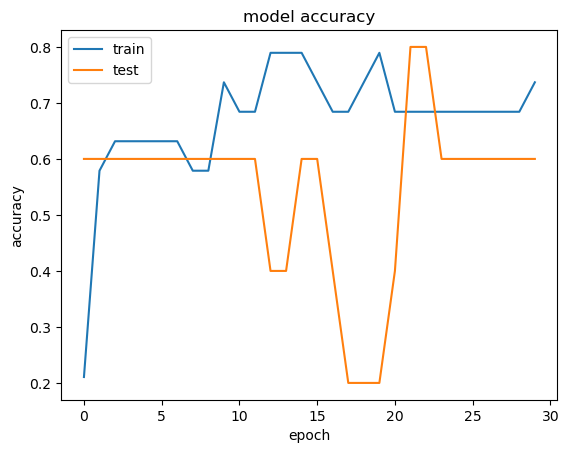

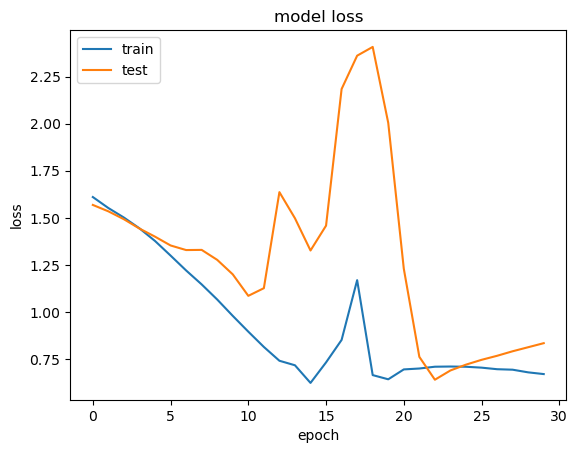

Matriz de valores para las palabras:
[[ 187  329  120 ...    0    0    0]
 [ 744  209  745 ...  803  804  221]
 [  14  133  805 ...    0    0    0]
 ...
 [2028  225  633 ...  335 2090 2091]
 [  10   42 2092 ...    0    0    0]
 [2142  130 2143 ...  643 2196   20]]
['Objetos', 'Lugares', 'Animales', 'Lugares', 'Lugares', 'Animales', 'Personas', 'Series', 'Personas', 'Series', 'Personas', 'Series', 'Objetos', 'Personas', 'Animales', 'Objetos', 'Lugares', 'Animales', 'Series', 'Lugares', 'Animales', 'Animales', 'Series', 'Lugares']
1/1 [==============================] - 0s 173ms/step


2023-10-20 22:07:47.573114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-20 22:07:47.573555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-20 22:07:47.574132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

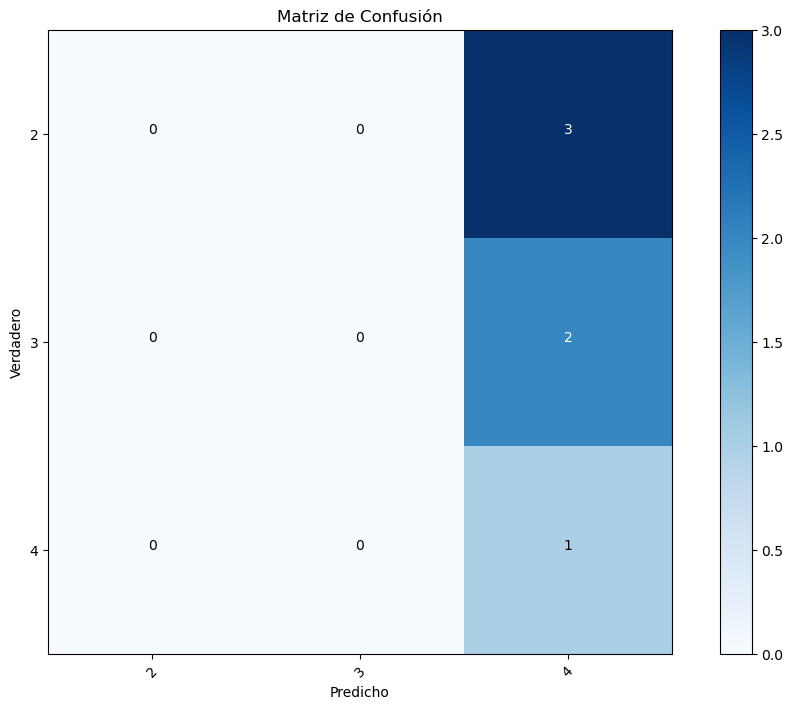

In [40]:
# Se hace la red neuronal de LSTM
LSTM_model(vocab_size, embedding_matrix, 150, y_train, y_test, X_train, X_test)